In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

#### Задача
1) Выбрать и обучить бейзлайновую модель  
2) при необходимости учесть особенности предобработки данных для модели  
3) построить кроссвалидацию для временных рядов и использовать ее для оценки модели (если вы решили использовать какую-то другую схему кроссвалидации - отразите это в своем ноутбуке, желательно со ссылкой на источник - мне тоже будет интересно почитать статьи про альтернативы)  
4) проинтерпретировать решения модели, насколько это возможно  
5) финально оценить качество на тестовой выборке  
6) попробовать улучшить результат, работая с данными (генерация признаков, отсев признаков, другой способ предобработки и тп) или подбирая гиперпараметры модели, если они есть  

In [465]:
# предвыгруженная информация из файлов (задание EDA)
data=pd.read_csv('collected_data.xlsx',index_col=0).set_index('date',drop=True).drop('index',axis=1)

In [466]:
data.index=pd.to_datetime(data.index, errors='coerce')

In [434]:
company_names=data.company_name.unique()

In [435]:
dict_companies={}
for name in company_names:
    dict_companies[f'{name}_data']=data.query('company_name==@name')
    dict_companies[f'{name}_train_data']=data.query('company_name==@name')[:-4]

### Блок с макроданными
Идеи: цена на нефть, газ, индекс акций (Dow John's, etc), ВВП США, экспорт нефти США, добыча нефти

In [311]:
import yfinance as yf

In [326]:
DJI = yf.Ticker("^DJI")
DJI_hist = msft.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

In [336]:
brent_oil=yf.Ticker("BZ=F")
hist_oil = brent_oil.history(period="max").drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])

### Блок с моделями

#### L2 linear model

In [436]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

In [437]:
data=data.merge(DJI_hist,left_index=True,right_index=True).merge(hist_oil,left_index=True,right_index=True)\
        .rename(columns={'Close_x':'Dow_John_s','Close_y':'Brent_price'})

In [438]:
ampy=data[data['company_name']=='AMPY.xlsx'].drop(columns=['company_name','company_number'])

In [463]:
#слабая корреляция, необходимо добавить ещё макроданных
ampy.corr()

,op_in,revenue,Dow_John_s,Brent_price
op_in,1.000000,0.813734,-0.315832,0.299705
revenue,0.813734,1.000000,-0.083631,0.174266
Dow_John_s,-0.315832,-0.083631,1.000000,-0.472046
Brent_price,0.299705,0.174266,-0.472046,1.000000


In [440]:
X=ampy.drop(columns=['op_in','revenue'])
X.insert(0, "intercept", 1)
y=ampy.revenue

In [441]:
X_train=X[:-4]
y_train=y[:-4]
X_test=X[-4:]
y_test=y[-4:]

In [442]:
ridge=Ridge(fit_intercept=False)

In [443]:
ridge.fit(X_train,y_train)

Ridge(fit_intercept=False)

In [444]:
y_pred=ridge.predict(X_test)

In [445]:
cross_val_score(ridge, X_train, y_train, cv=10, scoring='r2')

array([ 0.00000000e+00, -2.33820658e+00, -1.84827502e+02, -1.28974266e+02,
       -1.42134562e+01, -9.25499646e-02, -5.84488073e+02, -1.24802172e+02,
       -9.80354365e+02, -2.22262086e+01])

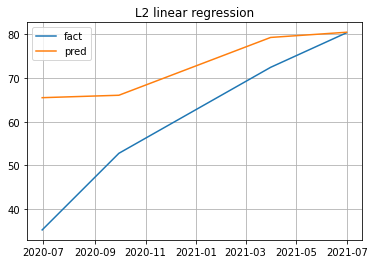

In [458]:
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
plt.title('L2 linear regression')
plt.grid()
plt.show()

In [447]:
mse(y_test,y_pred)

3529.8645292090696

In [448]:
r2_score(y_test,y_pred)

-10.38378302540835

### Random Forest Regressor

In [449]:
from sklearn.ensemble import RandomForestRegressor

In [450]:
rf=RandomForestRegressor()

In [451]:
rf.fit(X_train,y_train)

RandomForestRegressor()

In [452]:
y_pred=rf.predict(X_test)

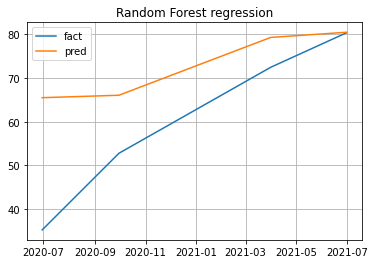

In [460]:
plt.plot(y_test, label='fact')
plt.plot(pd.DataFrame({'pred':y_pred},index=y_test.index), label='pred' )
plt.legend()
plt.title('Random Forest regression')
plt.grid()
plt.show()

In [454]:
mse(y_test,y_pred)

286.06956995047506

In [455]:
r2_score(y_test,y_pred)

0.07742807477719982

### ARIMA без макроданных

In [ ]:
data=pd.read_csv('collected_data.xlxs',index_col=0).set_index('date',drop=True).drop('index',axis=1)

$l_{1}$ - оператор разностей

In [3]:
data['op_in_l1']=(data.op_in.shift(-1)-data.op_in).fillna(0)
data['revenue_l1']=(data.revenue.shift(-1)-data.revenue).fillna(0)
data['op_in_l2']=(data.op_in_l1.shift(-1)-data.op_in_l1).fillna(0)
data['revenue_l2']=(data.revenue_l1.shift(-1)-data.revenue_l1).fillna(0)
data['op_in_l3']=(data.op_in_l2.shift(-1)-data.op_in_l2).fillna(0)
data['revenue_l3']=(data.revenue_l2.shift(-1)-data.revenue_l2).fillna(0)

In [ ]:
dict_companies={}
for name in company_names:
    dict_companies[f'{name}_data']=data.query('company_name==@name')
    dict_companies[f'{name}_train_data']=data.query('company_name==@name')[:-4]

In [272]:
import statsmodels.tsa.stattools as stools
from statsmodels.tsa.arima.model import ARIMA

Revenue

In [274]:
import warnings
warnings.filterwarnings("ignore")

In [275]:
dict_companies['AMPY.xlsx_train_data']shape

(38, 10)

In [306]:
from pmdarima import auto_arima

Расчёт параметров для revenue

**Augmented Dickey–Fuller test and ARMA order selection**  
(пытался самостоятельно рассчитать p,d,q), впоследствии от идеи отказался

In [268]:
%%time
arima_parameters={}
for name in company_names:

    #нахождение порядка интегрируемости через тестирование стационарности
    #если находим порядок интегрируемости, записываем порядки AR(p), I, MA(q) в словарь с порядками для рядов всех компний
    #если стационарности нет, переходим к следующей разности
    p=stools.adfuller(dict_companies[f'{name}_data'].revenue,regression='c')[1]
    if p<0.05:
        arma=stools.arma_order_select_ic(dict_companies[f'{name}_data'].revenue,max_ar=3,max_ma=3,ic='bic')['bic_min_order']
        #print(name,arma,0)
        arima_parameters[name]=[arma[0],0,arma[1] ]
        continue
    #первая разность
    p=stools.adfuller(dict_companies[f'{name}_data'].revenue_l1,regression='c')[1]
    if p<0.05:
        arma=stools.arma_order_select_ic(dict_companies[f'{name}_data'].revenue_l1,max_ar=3,max_ma=3,ic='bic')['bic_min_order']
        #print(name,arma,1)
        arima_parameters[name]=[arma[0],1,arma[1] ]
        continue
    #вторая разность
    p=stools.adfuller(dict_companies[f'{name}_data'].revenue_l2,regression='c')[1]
    if p<0.05:
        p_values[name]=p
        arma=stools.arma_order_select_ic(dict_companies[f'{name}_data'].revenue_l2,max_ar=3,max_ma=3,ic='bic')['bic_min_order']
        #print(name,arma,2)
        arima_parameters[name]=[arma[0],2,arma[1] ]
        continue
    #третья разность
    p=stools.adfuller(dict_companies[f'{name}_data'].revenue_l3,regression='c')[1]
    arma=stools.arma_order_select_ic(dict_companies[f'{name}_data'].revenue_l3,max_ar=3,max_ma=3,ic='bic')['bic_min_order']
    #print(name,arma,3)
    arima_parameters[name]=[arma[0],3,arma[1] ]
    continue

CPU times: total: 41.9 s
Wall time: 42 s


In [186]:
from sklearn.metrics import r2_score, mean_squared_error as mse

In [260]:
y_fact=dict_companies['AMPY.xlsx_data'].revenue.tail(4)
y_pred=fit_model.predict(start=38,end=41)

In [261]:
y_fact.index=pd.to_datetime(y_fact.index, errors='coerce')

Результаты:

In [310]:
for name in company_names:
    arima_model=auto_arima(dict_companies[f'{name}_train_data'].revenue, seasonal=True)
    y_fact=dict_companies[f'{name}_data'].revenue.tail(4)
    y_pred=auto_ampy.predict(4)
    y_fact.index=pd.to_datetime(y_fact.index, errors='coerce')
    print(f'{name},\t mse:',mse(y_fact, y_pred),end='\t')
    print('r2_score:',r2_score(y_fact, y_pred))

AMPY.xlsx,	 mse: 1269.8862230651491	r2_score: -8.73939493273097
APA.xlsx,	 mse: 2324047.6956488467	r2_score: -14.1679751913621
AR.xlsx,	 mse: 1360728.647242886	r2_score: -6.994621158624775
BATL.xlsx,	 mse: 494.8330942293909	r2_score: -6.075505434809186
BCEI.xlsx,	 mse: 4780.998069649391	r2_score: -2.029327142851754
BRY.xlsx,	 mse: 4401.823427496816	r2_score: -8.067320873736948
BSM.xlsx,	 mse: 946.903234337449	r2_score: -5.615604555732931
CDEV.xlsx,	 mse: 16201.94684053987	r2_score: -17.03810237949414
CHK.xlsx,	 mse: 982724.9229747445	r2_score: -23.047968862562577
CLR.xlsx,	 mse: 986480.5041380131	r2_score: -17.098311884045064
CNX.xlsx,	 mse: 117626.23660307578	r2_score: -65.14944608101992
COG.xlsx,	 mse: 120519.64040468688	r2_score: -25.31851406960614
COP.xlsx,	 mse: 58850727.0507217	r2_score: -9.132169553608088
CPE.xlsx,	 mse: 102709.72784122161	r2_score: -26.87455037890264
CRC.xlsx,	 mse: 120801.8453949684	r2_score: -51.064150585052644
CRK.xlsx,	 mse: 68246.51828307725	r2_score: -14.

Вывод: без макроданных и без учёта сезонности результат неудовлетворительный

Работа с сезонностью:

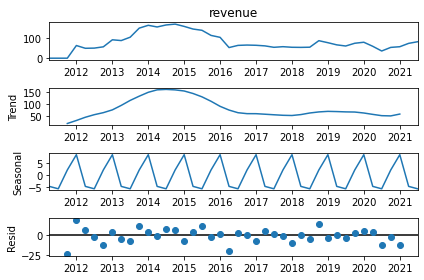

In [401]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dict_companies['AMPY.xlsx_data'].revenue)
result.plot();

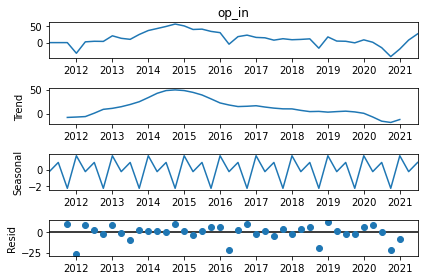

In [405]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dict_companies['AMPY.xlsx_data'].op_in)
result.plot();